## Casual Analysis of Risk factors associated with depression

In [63]:
import numpy as np
import pandas as pd

import os
from functools import reduce  

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error


## Load Data

In [64]:
# full data
full_data = pd.DataFrame()

# from each file
for filename in os.listdir('data'):
    if(filename.endswith(".XPT")):
        file = os.path.join('data', filename)
        newcols = pd.read_sas(file, encoding='UTF-8')
        
        if(len(full_data) == 0):
            full_data = newcols
        else:
            full_data = pd.merge(full_data, newcols, on = "SEQN", how = "outer")

#in case we want the file in csv
full_data.to_csv('data/data_combined.csv')

print(full_data.shape)

(9254, 301)


**3344** rows with values 

In [65]:
cols = full_data.loc[:,"DPQ010":"DPQ100"].columns
valid = full_data.copy()
# valid[cols] = valid[cols].round()

# only care about values 0-3
for i in range(len(cols)):
    valid = valid.loc[valid[cols[i]] <=3]

# sum_dp
valid["sum_DPQ"] = valid[cols].sum(axis="columns", skipna = True)
print(valid.shape)
valid.describe()

(3344, 302)


,SEQN,ALQ111,ALQ121,ALQ130,ALQ142,ALQ270,ALQ280,ALQ290,ALQ151,ALQ170,...,WHD080L,WHQ225,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ190,WHQ200,sum_DPQ
count,3344.000000,3342.000000,3.023000e+03,2341.000000,2.341000e+03,1.040000e+03,1.040000e+03,3.800000e+02,3023.000000,2.229000e+03,...,22.0,3344.000000,2345.000000,2815.000000,1664.000000,3343.000000,3310.000000,3344.000000,53.000000,3344.000000
mean,98297.694378,1.095452,4.959643e+00,3.860316,3.499786e+00,4.198077e+00,3.160577e+00,4.544737e+00,1.841217,7.921041e+00,...,40.0,3.264055,476.912154,482.402487,370.633413,292.377804,637.620846,1.984151,42.509434,5.227572
std,2680.753547,0.293882,3.912557e+00,35.722023,6.161198e+00,7.614332e+00,7.172170e+00,9.421841e+00,0.434980,7.616430e+01,...,0.0,1.798048,1686.002440,1765.723266,1712.586305,928.690675,7670.812149,0.124911,11.500205,4.745192
min,93711.000000,1.000000,5.397605e-79,1.000000,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1.000000,5.397605e-79,...,40.0,1.000000,78.000000,70.000000,41.000000,90.000000,12.000000,1.000000,21.000000,1.000000
25%,95951.500000,1.000000,1.000000e+00,1.000000,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,2.000000,5.397605e-79,...,40.0,1.000000,145.000000,125.000000,63.000000,160.000000,26.000000,2.000000,35.000000,2.000000
50%,98315.000000,1.000000,5.000000e+00,2.000000,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,2.000000,5.397605e-79,...,40.0,4.000000,170.000000,148.000000,66.000000,193.000000,39.000000,2.000000,42.000000,4.000000
75%,100592.500000,1.000000,8.000000e+00,3.000000,7.000000e+00,9.000000e+00,7.000000e+00,9.000000e+00,2.000000,1.000000e+00,...,40.0,5.000000,208.000000,180.000000,70.000000,236.000000,54.000000,2.000000,51.000000,7.000000
max,102956.000000,2.000000,9.900000e+01,999.000000,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.000000,9.990000e+02,...,40.0,9.000000,9999.000000,9999.000000,9999.000000,9999.000000,99999.000000,2.000000,61.000000,28.000000


In [66]:
# chosen variables, SEQN removed
features = ['SEQN','RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
            'INDHHIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
            'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012', 'sum_DPQ']


subdata = full_data.filter(items=features)
subdata = subdata[subdata.RIDAGEYR >= 18]
subdata_features = subdata.filter(items=['RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDHHSIZ',
            'INDHHIN2', 'BMXBMI', 'URXUAS', 'URXUHG', 'ALQ130', 'DUQ217', 'FSD230', 'INDFMMPI',
            'PAD680', 'OCQ180', 'OCQ210', 'SMQ040', 'SMD650', 'SLD012'])

In [67]:
# percentage null values 
subdata.isnull().mean() * 100

SEQN         0.000000
RIAGENDR     0.000000
RIDAGEYR     0.000000
RIDRETH1     0.000000
DMDCITZN     0.051230
DMDEDUC2     4.900956
DMDHHSIZ     0.000000
INDHHIN2     5.959699
BMXBMI       7.206284
URXUAS      69.262295
URXUHG      69.176913
ALQ130      40.317623
DUQ217      85.177596
FSD230      77.885929
INDFMMPI    20.543033
PAD680       0.170765
OCQ180      47.558060
OCQ210      83.811475
SMQ040      59.716530
SMD650      82.786885
SLD012       0.802596
dtype: float64

In [68]:
subdata.shape

(5856, 21)

In [69]:
subdata.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,BMXBMI,URXUAS,...,ALQ130,DUQ217,FSD230,INDFMMPI,PAD680,OCQ180,OCQ210,SMQ040,SMD650,SLD012
0,93705.0,2.0,66.0,4.0,1.0,2.0,1.0,3.0,31.7,NaN,...,1.0,NaN,NaN,0.49,300.0,30.0,1.0,3.0,NaN,8.0
1,93706.0,1.0,18.0,5.0,1.0,NaN,5.0,NaN,21.5,NaN,...,NaN,NaN,NaN,NaN,240.0,NaN,NaN,NaN,NaN,10.5
2,93708.0,2.0,66.0,5.0,1.0,1.0,2.0,6.0,23.7,24.07,...,NaN,NaN,NaN,1.46,120.0,NaN,NaN,NaN,NaN,8.0
3,93709.0,2.0,75.0,4.0,1.0,4.0,1.0,2.0,38.9,NaN,...,NaN,NaN,NaN,0.96,600.0,NaN,NaN,1.0,5.0,7.0
4,93711.0,1.0,56.0,5.0,1.0,5.0,3.0,15.0,21.3,2.89,...,1.0,NaN,NaN,5.00,420.0,35.0,NaN,NaN,NaN,7.0


In [70]:
subdata.tail()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,BMXBMI,URXUAS,...,ALQ130,DUQ217,FSD230,INDFMMPI,PAD680,OCQ180,OCQ210,SMQ040,SMD650,SLD012
9244,102751.0,2.0,19.0,3.0,1.0,NaN,3.0,12.0,NaN,NaN,...,NaN,NaN,2.0,NaN,120.0,12.0,2.0,NaN,NaN,10.0
9245,102804.0,1.0,30.0,1.0,2.0,2.0,3.0,8.0,NaN,NaN,...,NaN,NaN,NaN,1.73,300.0,50.0,NaN,NaN,NaN,6.0
9246,102825.0,2.0,80.0,3.0,1.0,3.0,2.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,420.0,NaN,NaN,3.0,NaN,8.5
9252,102940.0,2.0,77.0,3.0,1.0,3.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,600.0,NaN,NaN,NaN,NaN,9.0
9253,102950.0,1.0,64.0,4.0,1.0,3.0,2.0,7.0,NaN,NaN,...,NaN,NaN,NaN,2.48,60.0,70.0,NaN,3.0,NaN,7.0


In [71]:
# left join rows with sum_DPQ != null with subdata

valid = valid[features]
valid.columns

sample = pd.merge(valid, subdata, how = "left")
sample


,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDHHSIZ,INDHHIN2,BMXBMI,URXUAS,...,DUQ217,FSD230,INDFMMPI,PAD680,OCQ180,OCQ210,SMQ040,SMD650,SLD012,sum_DPQ
0,93711.0,1.0,56.0,5.0,1.0,5.0,3.0,15.0,21.3,2.89,...,NaN,NaN,5.00,420.0,35.0,NaN,NaN,NaN,7.0,2.0
1,93712.0,1.0,18.0,1.0,2.0,NaN,4.0,4.0,19.7,0.82,...,NaN,1.0,0.76,120.0,55.0,NaN,2.0,2.0,7.5,1.0
2,93713.0,1.0,67.0,3.0,1.0,3.0,1.0,6.0,23.5,NaN,...,NaN,NaN,2.99,120.0,NaN,NaN,1.0,15.0,5.5,9.0
3,93714.0,2.0,54.0,4.0,1.0,4.0,3.0,7.0,39.9,5.48,...,NaN,NaN,1.29,360.0,NaN,1.0,3.0,NaN,7.0,2.0
4,93715.0,1.0,71.0,5.0,1.0,3.0,5.0,8.0,22.5,NaN,...,NaN,1.0,0.90,180.0,NaN,NaN,1.0,25.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,102935.0,2.0,27.0,3.0,1.0,5.0,2.0,14.0,23.6,NaN,...,NaN,NaN,0.85,720.0,NaN,NaN,NaN,NaN,8.0,15.0
3340,102943.0,2.0,48.0,1.0,1.0,4.0,6.0,15.0,37.4,NaN,...,NaN,NaN,4.88,60.0,38.0,NaN,NaN,NaN,5.5,1.0
3341,102947.0,1.0,75.0,4.0,1.0,5.0,1.0,8.0,25.2,7.73,...,NaN,NaN,2.97,240.0,30.0,2.0,3.0,NaN,7.0,1.0
3342,102953.0,1.0,42.0,1.0,2.0,3.0,1.0,12.0,35.8,NaN,...,NaN,NaN,NaN,360.0,42.0,NaN,3.0,NaN,6.0,4.0


## Clean Data

### n = 3344 original


In [72]:
## clean

# sample = sample.loc[sample["DMDCITZN"].notna()]

# sample = sample.loc[sample["BMXBMI"].notna()]

# sample = sample.loc[sample["PAD680"].notna()]
# sample.loc[sample.notna()]

columns_mostly_complete = sample.columns[(valid.isnull().mean() * 100)  <= 20]


sample = sample.loc[:, columns_mostly_complete.values]
sample = sample.dropna(axis = "rows")

### Feature selection

In [73]:
sample.isnull().mean() * 100

SEQN        0.0
RIAGENDR    0.0
RIDAGEYR    0.0
RIDRETH1    0.0
DMDCITZN    0.0
DMDEDUC2    0.0
DMDHHSIZ    0.0
INDHHIN2    0.0
BMXBMI      0.0
INDFMMPI    0.0
PAD680      0.0
SLD012      0.0
sum_DPQ     0.0
dtype: float64

In [74]:

X = sample.loc[:, ~sample.columns.isin(['SEQN','sum_DPQ'])]
y = sample.loc[:, ['sum_DPQ']]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42)

linearmodel = LinearRegression()
# sfs = SequentialFeatureSelector(linearmodel, direction = "backward", cv = 5, n_features_to_select = 5)
sfs = SequentialFeatureSelector(linearmodel, direction = "backward", cv = 5, n_features_to_select = 5)

sfs = sfs.fit(X, y)

# final selected features
backward_selected_features = X.columns.values[sfs.get_support()]
backward_selected_features

array(['RIAGENDR', 'DMDEDUC2', 'DMDHHSIZ', 'BMXBMI', 'INDFMMPI'],
      dtype=object)

In [75]:
len(features)

22

# Fit linear regression

In [76]:
X = sample.loc[:, sample.columns.isin(backward_selected_features)]
y = sample.loc[:, ['sum_DPQ']]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.33, random_state = 42)

linear_model = LinearRegression(normalize = True )
linear_model = linear_model.fit(X_train, y_train)


y_pred = linear_model.predict(X_test)

r2 = linear_model.score(X_test, y_test)
MSE = mean_squared_error(y_test, y_pred)
print(f'MSE (LM Backwards selected features): {MSE}\nRsquared: {r2}')


(2553, 5)
(2553, 1)
MSE (LM Backwards selected features): 18.444044295771302
Rsquared: 0.04475289642566338


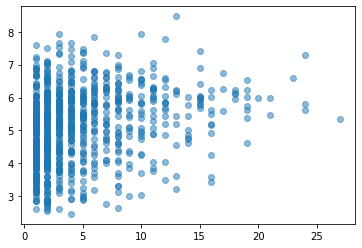

In [79]:

linear_model
plt.scatter(y_test, y_pred, alpha = 0.5)